# Neural Networks for Data Science Applications
## Final Homework: Putting everything together

**Name**: *Trina Sahoo*

**Matricola**: *1901254*

Send the completed notebook before 15-01-2021 back to **simone.scardapane@uniroma1.it** with the object "[NNDS] Homework_2_\<id\>".

**Overview**: The homework is composed of four parts: (i) select a dataset; (ii) implement a custom component (ONLY if you did not submit the first homework); (iii) implement a neural network and train it on the dataset; (iv) perform a post-training operation on the method (interpretation / robustness / fairness).

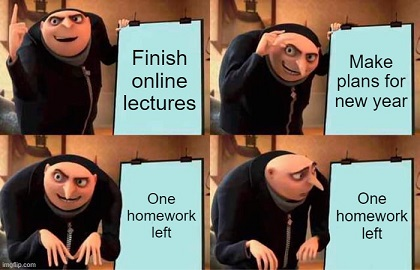

In [ ]:
! pip install lime

     |████████████████████████████████| 276kB 6.0MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=065270d7bfbb4c5d7cc00c5dc2e62059de540f4a5d54c1b53dd83075d25b3cb0
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
# libraries for importing dataset  
import pandas as pd
import numpy as np
import urllib.request as urllib

# libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler 


# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization

#Interpreting
import lime
import lime.lime_tabular

**Important - before starting**: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*.

### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts)... The task can be either classification or a more complex task (e.g., segmentation, sequence prediction, ...). *For tasks beyond classification, check carefully that the final exercise is viable before starting your implementation.*

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark, so you can select a complexity that you believe adequate to your skills.

**DESCRIPTION OF THE CODE**: In this homework we analyze a U.S. census data taken from the UCI (University of California at Irvine) Machine Learning Repository. Our final goal is to build a model, which can predict whether the income of a random adult citizen is less or greater than 50000$ a year based on given features, such as age, education, occupation, gender, race, etc.
The URL of the dataset : https://archive.ics.uci.edu/ml/datasets/census+income 

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/census-income/census-income.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/census-income/census-income.test

--2021-02-16 18:08:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/census-income/census-income.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘census-income.data’

census-income.data  100%[===================>]   3.79M  9.01MB/s    in 0.4s    

2021-02-16 18:08:22 (9.01 MB/s) - ‘census-income.data’ saved [3974305/3974305]

--2021-02-16 18:08:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/census-income/census-income.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘census-income.test’

census-income.test  100%[====

In [ ]:
column = ["age", "workclass", "fnlwgt", "education", "education_num", "marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"] 

In [ ]:
train = pd.read_csv("census-income.data", header = None, names = column)
train.head()

age          workclass  fnlwgt  ... hours-per-week  native-country  income
0   39          State-gov   77516  ...             40   United-States   <=50K
1   50   Self-emp-not-inc   83311  ...             13   United-States   <=50K
2   38            Private  215646  ...             40   United-States   <=50K
3   53            Private  234721  ...             40   United-States   <=50K
4   28            Private  338409  ...             40            Cuba   <=50K

[5 rows x 15 columns]

In [ ]:
test = pd.read_csv("census-income.test", skiprows = 1, sep = ",", names = column)
test.head()

age   workclass  fnlwgt  ... hours-per-week  native-country   income
0   25     Private  226802  ...             40   United-States   <=50K.
1   38     Private   89814  ...             50   United-States   <=50K.
2   28   Local-gov  336951  ...             40   United-States    >50K.
3   44     Private  160323  ...             40   United-States    >50K.
4   18           ?  103497  ...             30   United-States   <=50K.

[5 rows x 15 columns]

### Missing value:
In order to get rid of missing values, we obtain the value count of all the variables and observe the “?” and replace the “?” with the mode.
From the output of the value count we observe that there are “?” in 3 columns, ie., workclass, occupation and native country. Then we replace the “?” of workclass with the category “Private” which has the highest count. Similarly, we have replaced “?” of occupation with the category “Prof-Specialty” and native-country with the category “United-States”. We have performed the same for both train and test dataset.

In [ ]:
# Function to obtain the value count for all the columns
col_names = train.columns
for i in col_names:
  count = train[i].value_counts()
  print(i)
  print(count)

age
36    898
31    888
34    886
23    877
35    876
     ... 
83      6
85      3
88      3
87      1
86      1
Name: age, Length: 73, dtype: int64
workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
fnlwgt
164190    13
203488    13
123011    13
113364    12
121124    12
          ..
284211     1
312881     1
177711     1
179758     1
229376     1
Name: fnlwgt, Length: 21648, dtype: int64
education
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          

In [ ]:
# Replacing ? with mode

train['workclass'] = train['workclass'].replace(' ?', 'Private')
train['occupation'] = train['occupation'].replace(' ?', 'Prof-specialty')
train['native-country'] = train['native-country'].replace(' ?', 'United-States')

In [ ]:
train.head()

age          workclass  fnlwgt  ... hours-per-week  native-country  income
0   39          State-gov   77516  ...             40   United-States   <=50K
1   50   Self-emp-not-inc   83311  ...             13   United-States   <=50K
2   38            Private  215646  ...             40   United-States   <=50K
3   53            Private  234721  ...             40   United-States   <=50K
4   28            Private  338409  ...             40            Cuba   <=50K

[5 rows x 15 columns]

The value count for each column and replacing the "?" with mode for the test dataset

In [ ]:
# Function to obtain the value count for all the columns
col_names = test.columns
for i in col_names:
  count = test[i].value_counts()
  print(i)
  print(count)

age
35    461
33    460
23    452
36    450
38    437
     ... 
88      3
84      3
89      2
85      2
87      2
Name: age, Length: 73, dtype: int64
workclass
 Private             11210
 Self-emp-not-inc     1321
 Local-gov            1043
 ?                     963
 State-gov             683
 Self-emp-inc          579
 Federal-gov           472
 Without-pay             7
 Never-worked            3
Name: workclass, dtype: int64
fnlwgt
136986    9
127651    8
203488    8
190290    8
120277    8
         ..
119344    1
240175    1
45612     1
346478    1
235523    1
Name: fnlwgt, Length: 12787, dtype: int64
education
 HS-grad         5283
 Some-college    3587
 Bachelors       2670
 Masters          934
 Assoc-voc        679
 11th             637
 Assoc-acdm       534
 10th             456
 7th-8th          309
 Prof-school      258
 9th              242
 12th             224
 Doctorate        181
 5th-6th          176
 1st-4th           79
 Preschool         32
Name: education, dtype: 

In [ ]:
# Replacing ? with mode

test['workclass'] = test['workclass'].replace(' ?', 'Private')
test['occupation'] = test['occupation'].replace(' ?', 'Prof-specialty')
test['native-country'] = test['native-country'].replace(' ?', 'United-States')

In [ ]:
test.head()

age   workclass  fnlwgt  ... hours-per-week  native-country   income
0   25     Private  226802  ...             40   United-States   <=50K.
1   38     Private   89814  ...             50   United-States   <=50K.
2   28   Local-gov  336951  ...             40   United-States    >50K.
3   44     Private  160323  ...             40   United-States    >50K.
4   18     Private  103497  ...             30   United-States   <=50K.

[5 rows x 15 columns]

### Encoding: 

At first the income category <=50K and >50K is classified to 0 and 1 respectively for both train and test dataset. Then the categorical variables are considered and transformed into numerical values using LebelEncoding function.




In [ ]:
# Income for train data

train.income = train.income.replace(" <=50K", 0)
train.income = train.income.replace(" >50K", 1)

In [ ]:
# Income for test data

test.income = test.income.replace(" <=50K.", 0)
test.income = test.income.replace(" >50K.", 1)

In [ ]:
# list of the categorial columns
categorical = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

# function for encoding the categorical columns
for features in categorical:
  le = preprocessing.LabelEncoder()
  train[features] = le.fit_transform(train[features])
  test[features] = le.transform(test[features])


### Train and test dataset split:

Splitting the train data as x_train and y_train. x_train contains all the
features except income column and y_train contain the target variable, that is, the income column. Similarly, the test data is splitted into x_test and y_test where x_test contains all the features except the income column and y_test contains the target variable.


In [ ]:
x_train = train.drop('income', axis = 1)
y_train = train['income']

x_test = test.drop('income', axis = 1)
y_test = test['income']

### Standardization:

Standardization allows us to put different values on the same scale. It basically calculates the mean and the standard deviation for a variables and then standardize we subtract each observed value  of the variable by mean and divide it by standard deviation.

(array([[0., 0., 5., ..., 0., 0., 0.],
        [0., 1., 6., ..., 0., 0., 0.],
        [0., 0., 6., ..., 0., 0., 0.],
        ...,
        [0., 0., 6., ..., 0., 0., 0.],
        [0., 0., 6., ..., 0., 0., 0.],
        [0., 0., 5., ..., 0., 0., 0.]]),
 array([-5.99554116, -4.05652925, -2.11751734, -0.17850544,  1.76050647,
         3.69951838,  5.63853028,  7.57754219,  9.5165541 , 11.455566  ,
        13.39457791]),
 <a list of 32561 Lists of Patches objects>)

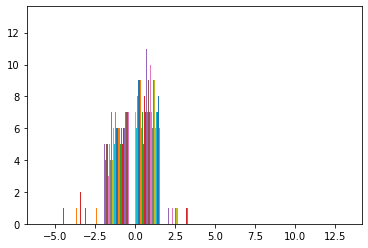

In [ ]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns) 
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

plt.hist(x_train)

In [ ]:
x_train.head()

age  workclass    fnlwgt  ...  capital-loss  hours-per-week  native-country
0  0.030671   1.658412 -1.063611  ...      -0.21666       -0.035429        0.251378
1  0.837109   1.026306 -1.008707  ...      -0.21666       -2.222153        0.251378
2 -0.042642  -0.237906  0.245079  ...      -0.21666       -0.035429        0.251378
3  1.057047  -0.237906  0.425801  ...      -0.21666       -0.035429        0.251378
4 -0.775768  -0.237906  1.408176  ...      -0.21666       -0.035429       -5.337971

[5 rows x 14 columns]

In [ ]:
x_test.head()

age  workclass    fnlwgt  ...  capital-loss  hours-per-week  native-country
0 -0.995706  -0.237906  0.350774  ...      -0.21666       -0.035429        0.251378
1 -0.042642  -0.237906 -0.947095  ...      -0.21666        0.774468        0.251378
2 -0.775768  -1.502118  1.394362  ...      -0.21666       -0.035429        0.251378
3  0.397233  -0.237906 -0.279070  ...      -0.21666       -0.035429        0.251378
4 -1.508894   2.922623 -0.817458  ...      -0.21666       -0.845327        0.251378

[5 rows x 14 columns]

### Exercise 1: Implement a custom object (5 points)

**This exercise is required only for students that have not submitted the mid-term homework, or for students who want to raise their mid-term mark (mark <= 3/5). For a mark of 4/5, an additional point can also be recovered during the exam.**

**To recap**: if you submitted the mid-term homework, implement only Exercises 2 and 3, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1, 2, and 3 for a total of *15 points*. 

[Papers With Code](https://paperswithcode.com/methods) is a repository of state-of-the-art tasks and components for deep networks, including:

1. [Optimizers](https://paperswithcode.com/methods/category/optimization)
2. [Residual components](https://paperswithcode.com/methods/category/skip-connection-blocks)
3. [Attention mechanisms](https://paperswithcode.com/methods/category/attention-mechanisms)
4. [Regularizers](https://paperswithcode.com/methods/category/regularization)
5. [Activation functions](https://paperswithcode.com/methods/category/activation-functions)
6. [Normalization blocks](https://paperswithcode.com/methods/category/normalization)
7. [Loss functions](https://paperswithcode.com/methods/category/loss-functions)
8. [Variants of feedforward networks](https://paperswithcode.com/methods/category/feedforward-networks)

Select a component in the categories above **not covered during the course**, and provide a working implementation in **TensorFlow 2.x**. A re-implementation is preferable; if you use an open implementation, state it clearly below. If you re-use parts of an open implementation, also state it clearly below.

**DESCRIPTION OF THE CODE**: *provide a small description of the method you have implemented, with all necessary links. If needed, explain why it is useful for the task you have selected (e.g., if implementing a different loss function).*

In [ ]:
# Insert your custom component here
class MyCustomDropout(tf.keras.Layer):
  # ...

In [ ]:
# Optionally, briefly show how the component can be used

### Exercise 2: Train on your data (5 points)

This part is straightforward: create a model, according to everything we saw in the course, and train it on the data you have loaded. If you did Exercise 1, **include your custom component here**. Otherwise, you are free to use any components that were not included in the course (layers, losses, metrics, ...), provided you give a brief description below.

**DESCRIPTION OF THE CODE**: *Provide a small description of (i) here sequential model has been used with dense layer and activation functions as relu, sigmoid, and softmax and also BatchNormalization layer (ii) the task is to predict whether the income of a person is greater than or less than 50K.*

In [ ]:
model = Sequential()

model.add(Dense(units = 128, activation = "relu", input_dim = 14))
model.add(BatchNormalization())
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'sigmoid'))
model.add(Dense(units = 2, activation = 'softmax'))


In [ ]:
model.compile(loss='SparseCategoricalCrossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test, y_test), batch_size=64, epochs = 10)

Epoch 1/10
509/509 [==============================] - 2s 2ms/step - loss: 0.4020 - accuracy: 0.8128 - val_loss: 0.3288 - val_accuracy: 0.8480
Epoch 2/10
509/509 [==============================] - 1s 2ms/step - loss: 0.3308 - accuracy: 0.8443 - val_loss: 0.3278 - val_accuracy: 0.8486
Epoch 3/10
509/509 [==============================] - 1s 2ms/step - loss: 0.3286 - accuracy: 0.8451 - val_loss: 0.3238 - val_accuracy: 0.8496
Epoch 4/10
509/509 [==============================] - 1s 2ms/step - loss: 0.3241 - accuracy: 0.8482 - val_loss: 0.3244 - val_accuracy: 0.8469
Epoch 5/10
509/509 [==============================] - 1s 2ms/step - loss: 0.3307 - accuracy: 0.8446 - val_loss: 0.3236 - val_accuracy: 0.8487
Epoch 6/10
509/509 [==============================] - 1s 2ms/step - loss: 0.3251 - accuracy: 0.8457 - val_loss: 0.3245 - val_accuracy: 0.8470
Epoch 7/10
509/509 [==============================] - 1s 2ms/step - loss: 0.3193 - accuracy: 0.8477 - val_loss: 0.3228 - val_accuracy: 0.8486
Epoch 

### Exercise 3 (5 points)

Training a model is only the beginning! Select **one of the three** paths below, and follow the instructions.

1. **Interpreting your model**: interpretability is critical in many applications. Good libraries for obtaining interpetations from your model are [tf-explain](https://github.com/sicara/tf-explain), the original [LIME implementation](https://github.com/marcotcr/lime), and IBM [AIX360 Toolbox](https://github.com/Trusted-AI/AIX360). For this path, select an interpretability method, *read carefully the original paper*, and test it on one of your input examples. You can use one of the basic methods seen in the course, or a more advanced variant (e.g., Gradients*Input, Integrated Gradients, ...).

2. **Attacking your model**: there are a number of libraries for crafting an adversarial attack. Possible alternatives are [CleverHans](https://github.com/tensorflow/cleverhans), [Foolbox](https://github.com/bethgelab/foolbox), or the [Adversarial Robustness Toolbox](https://github.com/Trusted-AI/adversarial-robustness-toolbox). Select one white-box adversarial attack, *read carefully the original paper*, and create an adversarial attack on your network. You can use FGSM as seen in the course, or a more advanced method (e.g., JSMA, ...).

3. **Fairness**: finally, you might want to evaluate whether your model is fair. Good libraries for this are [FAT Forensics](https://fat-forensics.org/) or IBM [AIF360 Toolbox](https://github.com/Trusted-AI/AIF360). For this exercise, select a fairness metric, and evaluate the group fairness on your dataset. Then, apply a post-processing to enforce the fairness, and evaluate the eventual variation in accuracy.

**DESCRIPTION OF THE CODE**: *Lime library has been used to interpret the model.Lime is used for individual prediction for any model. The idea behind lime is to decide whether a prediction can be trusted, improve the untrustworthy classificater and identify why a classifier should be trusted. At first we will train the lime explainer. Then we select a portion which we want to predict and check what actually has been predicted.*

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=np.array(x_train), feature_names=x_train.columns, class_names=['<=50K', '>50K'],
                                                   verbose = True, mode='classification')

Portion to be predicted that will be generated everytime randomly within the range of the number of columns of the test data

In [ ]:
print(y_test[1])

0


Intercept 0.8296878374439953
Prediction_local [0.18148772]
Right: 0.26257136


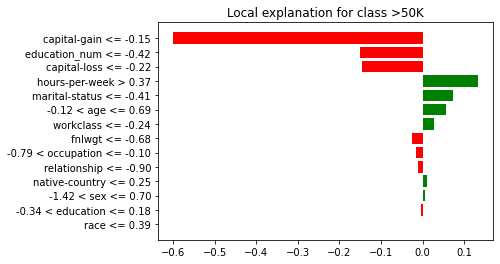

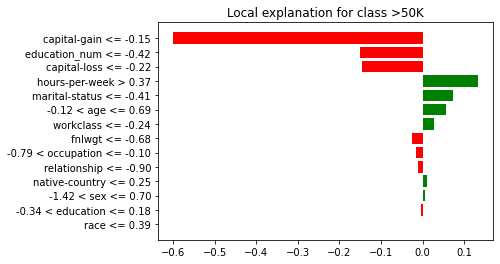

In [ ]:
exp = explainer.explain_instance(x_test.iloc[1], model.predict, num_features=x_test.shape[1])
exp.as_pyplot_figure()

The graph represents the influence of the factors like capital_gain, capital_loss, hours_per_week etc indicates that it's more inclined to class 0. As for class 1 the mentioned factors are negative.

In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)

**Interpretation**

In this case the model is 74% confident that the income of the individual is <=50K.

The values of capital gain, capital loss, education_num increases the chance of having the income <=50K.

The value of marital status, hours per week and age decreases the chance of having income <=50K.


In [ ]:
print(y_test[10])

1


Intercept 0.34871634038730226
Prediction_local [0.66032753]
Right: 0.38253805


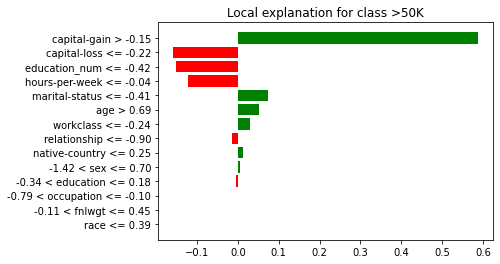

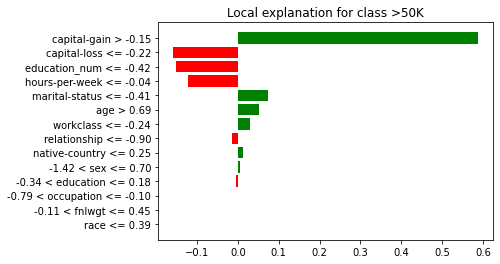

In [ ]:
exp = explainer.explain_instance(x_test.iloc[10], model.predict, num_features=x_test.shape[1])
exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)

**Interpretation**

In this case the model is 62% confident that the income of the individual is >50K.

The values of capital gain, marital status increases the chance of having the income >50K.

The value of capital loss, education number, hours per week decreases the chance of having income >50K.

### Conclusion

The neural network model used for this dataset works well which has been explained by LIME. The problem of interpretation of the neural network model also solved with the use of LIME. The interpretation for an individual prediction can be easily done with the help of this library.

### Reference
1. Interpretable Machine Learning Applications: Part 2 (Coursera)
2. https://towardsdatascience.com/interpreting-black-box-ml-models-using-lime-4fa439be9885


### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook before 15-01-2021 back to **simone.scardapane@uniroma1.it** with the object "[NNDS] Homework_2_\<id\>".

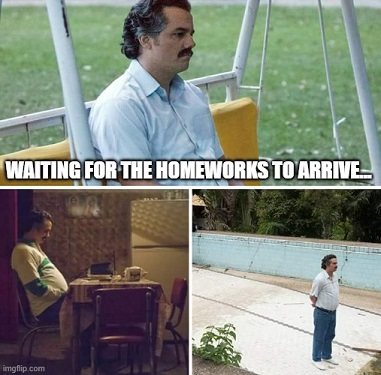